In [26]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
from evaluation_functions import *
from Bio import SeqIO
import matplotlib.patches as patches

In [27]:
base_dir = os.getcwd() 
amplicon = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"

amplicon_DNA = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'

amplicon_DNA_corrected = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'## since all the sequenced reads have an "A" instead of "G" at the 413th position of the LOV2 gene, we correct the sequence here

# correct the sequence
# LOV_gene_corrected = list(LOV_gene)
# LOV_gene_corrected[413] = "A"
# LOV_gene_corrected = "".join(LOV_gene_corrected)

amplicon_start = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGT"
amplicon_end = "GGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
LOV_gene_end_corr = "GAAAACATTGATGAAGCGGCCAAA"
LOV_gene_corrected = 'TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAA' ## since all the sequenced reads have an "A" instead of "G" at the 413th position, we correct the sequence here

LOV_gene = "TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAA"

LOV = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"
gene_len = len(LOV)*3
catch_left = 'AAGCAGCGGT'
catch_right = 'GGGAGCCTGC'
offset_left = 3
offset_right= 5

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [28]:
## RL8 AraC-LOV2
amplicon_DNA_seq = "CTGCTGGCGATTAACCTGCTGGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGC"
amplicon_AA_seq = translate_dna2aa(amplicon_DNA_seq)
catch_left = "AAGGA" # first of sequence added to catch left to make sure of starting before the triplet
catch_right = "ATGAT" # last of sequence added to catch right to make sure of ending after the triplet

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [417]:
dna_rev_comp("ATCAT")

'ATGAT'

In [306]:
Nt_codon_pref_dict = {0:{},
                     1:{},
                     2:{}}
for pos in range(3):
    for Nt in ["A", "C", "G","T"]:
        Nt_codon_pref_dict[pos][Nt] = sum([codon[pos] == Nt for codon in ecoli_pref.values()])


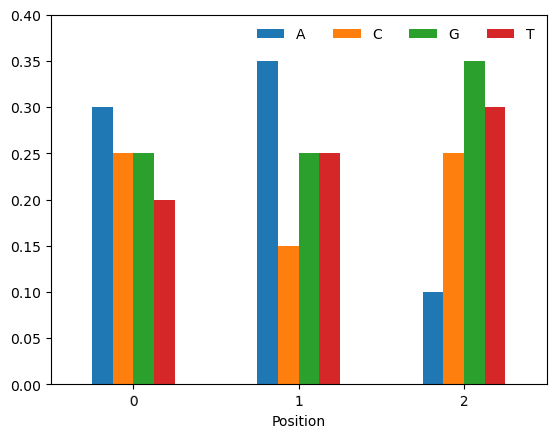

In [316]:
# grouped barplot from dict 
df = pd.DataFrame(Nt_codon_pref_dict)
df = df/df.sum(0)


df.transpose().plot.bar()
plt.legend(ncol = 4, frameon = False)
plt.ylim(0,0.4)
plt.xlabel("Position")
plt.xticks(rotation = 2)
plt.show()

# Functions

In [29]:
## evaluation 

### calculate sum of single, double and triple mutants
def gather_n_mutations(a_seq, b_seq, reference_seq, use_rev_read = True, use_forward_read = True, use_triplets = False):
    """
    returns a dictionary with the number of single, double, triple (...) mutants
    a_seq, b_seq = list of sequences
    """
    mutation_dict = {}
    catch_length = len(catch_left)
    
    
    for a_seq, b_seq in zip(a_seq, b_seq):
        
        if use_forward_read and catch_left in a_seq:
            index = a_seq.index(catch_left) + catch_length
            gene_a = a_seq[index:]
            if use_triplets: 
                n_muts_a_seq = sum([reference_seq[i:i+3] != gene_a[i:i+3] for i in range(0,len(gene_a)//3*3,3)])
            else: 
                n_muts_a_seq = sum([reference_seq[i] != gene_a[i] for i in range(len(gene_a))])

        else: n_muts_a_seq = 0
            
        if use_rev_read and dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                n_muts_b_seq = sum([reference_seq[::-1][i] != gene_b[i] for i in range(len(gene_b))])
                
        else: n_muts_b_seq = 0

        n_muts = n_muts_a_seq + n_muts_b_seq

        if n_muts in mutation_dict:
            mutation_dict[n_muts] += 1
        else:
            mutation_dict[n_muts] = 1

    return mutation_dict


### calculate the mutagenic spectrum
def mut_spectrum(a_seq, b_seq, reference_seq, use_rev_read = True, use_forward_read = True, catch_left = catch_left, catch_right = catch_right):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference nt: {mutated nt: count/percentage}}
    """
    ## reference nt : {mutated nt: count}
    mut_spec = {'A': {'A':0, 'C':0, 'G':0, 'T':0},
                'C': {'A':0, 'C':0, 'G':0, 'T':0},
                'G': {'A':0, 'C':0, 'G':0, 'T':0},
                'T': {'A':0, 'C':0, 'G':0, 'T':0}}
    
    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + len(catch_left)
                gene_a = a_seq[index:]
            
                for idx, nt in enumerate(gene_a): 
                    if reference_seq[idx] != nt:
                        mut_spec[reference_seq[idx]][nt] += 1
                
        if use_rev_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]

                for idx, nt in enumerate(gene_b):
                    if reference_seq[::-1][idx] != nt:
                        mut_spec[reference_seq[::-1][idx]][nt] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc

### calculate the mutagenic spectrum codon-wise
def mut_spectrum_codons(a_seq, b_seq, reference_seq, use_rev_read = False, use_forward_read = True, codon_list = codons, catch_left = catch_left, catch_right = catch_right):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum of codons and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference codon: {mutated codon: count/percentage}}
    """
    ## reference codon : {mutated codon: count}
    mut_spec = {ref_codon: {codon:0 for codon in codon_list} for ref_codon in codon_list}

    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + len(catch_left)
                gene_a = a_seq[index:]
                
                for idx in range(0,len(gene_a)//3*3,3): 
                    if reference_seq[idx:idx+3] != gene_a[idx:idx+3]:
                        mut_spec[reference_seq[idx:idx+3]][gene_a[idx:idx+3]] += 1
                
        if use_rev_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + len(catch_right)
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                
                for idx in range(0,len(gene_b)//3*3,3):
                    if reference_seq[::-1][idx:idx+3] != gene_b[idx:idx+3]:
                        mut_spec[reference_seq[::-1][idx:idx+3]][gene_b[idx:idx+3]] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc


def plot_mutation_spectrum(data, samplename , fig_folder = None, colormap = "viridis"):
    """
    plot mutation spectrum (%) as heatmap
    data = dataframe with the mutagenic spectrum (rows = reference nt, columns = mutated nt)
    savepath = folder path to save the figure
    """
    f, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(data, annot=True, linewidths=.5, ax=ax, vmin = 0, cbar = False, square = True, linecolor = "black", cmap = colormap)
    plt.xlabel('Mutated base (%)', fontsize = 10)
    plt.ylabel('Reference base (%)', fontsize = 10)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(.5)
    #ax.set_facecolor('gray')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=1, fontsize=10)
    plt.title(f"{samplename} mutagenic spectrum", fontsize = 12)
    if fig_folder is not None:
        plt.savefig(f"{fig_folder}/{samplename}_mutagenic_spectrum_perc.pdf")
    plt.show()



def coverage_plot(data, variant_name = "", xticks = list(range(0,430, 50)), FigFolder = None): 
    """
    data is a df with the coverage of each position, e.g by calling seq_variants["DNA"].sum()
    """

    ## plot coverage 

    ax = sns.barplot(data)
    plt.xticks(xticks)
    plt.xlabel("Position")
    plt.ylabel("Read counts")
    plt.title(f'{variant_name} DNA coverage')
    if FigFolder:
        plt.savefig(f'{FigFolder}/{variant_name}_DNA_coverage.pdf')
    plt.show()

def plot_mut_rate_per_pos(data, variant_name, FigFolder, ref_seq ):
    """
    data is a df with the mutation rate of each position, e.g by calling DNA_relative.sum()-DNA_relative.max() or seq_variants["DNA"].sum()-seq_variants["DNA"].max()/seq_variants["DNA"].sum()
    """
    plt.figure(figsize=(20,2))
    x_ticklabels = [Nt for Nt in ref_seq[:len(data)]]
    sns.heatmap(pd.DataFrame(data).T, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.02, "label": "Mutation rate" },linecolor="black", xticklabels=x_ticklabels, yticklabels=False)
    #ax.set_xticks(ticks = list(range(len(mut_rate_per_pos))),  labels = [Nt for Nt in LOV_gene[:len(mut_rate_per_pos)]])
    plt.xlabel("Position")
    plt.xticks(rotation = 2,fontsize=6)
    plt.title(variant_name)
    #plt.savefig(f"{FigFolder}/{name}_mutation_rate_per_Nt_position.pdf", bbox_inches="tight")
    plt.show()
    plt.clf()

# AraC analysis

### NOTE that the quality score cutoff is set to a 1 % error rate

In [30]:
## reload the evaluation functions
from importlib import reload
import evaluation_functions
reload(evaluation_functions)
from evaluation_functions import *

In [31]:
### set parameters
base_dir = os.getcwd()
variant = "RL8_AraCLOV2"
name = "RL8_AraCLOV2"
n_mut_treshold = 10
FigFolder = f"{base_dir}/output/{name}/R1"
use_rev_read = False
use_forward_read = True
arbitrary_cutoff_a = False
arbitrary_cutoff_b = False
amplicon_AA = amplicon_AA_seq #LOV#LOV#amplicon_AA_seq
amplicon_DNA = amplicon_DNA_seq #LOV_gene_corrected
#LOV_gene_corrected #amplicon_DNA_seq


# if not os.path.exists(FigFolder):
#     os.makedirs(FigFolder)

## read sequences
seq_variants = process_reads(ref_prot=amplicon_AA, ref_gene = amplicon_DNA, variants = [variant], use_rev_read=use_rev_read, use_forward_read=use_forward_read, arbitrary_cutoff_a=arbitrary_cutoff_a, arbitrary_cutoff_b=arbitrary_cutoff_b, n_mut_treshold = n_mut_treshold, filter_for_n_mut=True, catch_left= catch_left, catch_right=catch_right, codons = codons)

seq_variants["DNA"] = pd.DataFrame.from_dict(seq_variants[variant]["DNA"])
if not use_forward_read or not use_rev_read: 
    seq_variants["DNA"] = seq_variants["DNA"].loc[:,seq_variants["DNA"].sum() > 0]
seq_variants["AA"] = pd.DataFrame.from_dict(seq_variants[variant]["AA"])
if not use_forward_read or not use_rev_read: 
    seq_variants["AA"] = seq_variants["AA"].loc[:,seq_variants["AA"].sum() > 0]
seq_variants["Codons"] = pd.DataFrame.from_dict(seq_variants[variant]["Codons"])
if not use_forward_read or not use_rev_read: 
    seq_variants["Codons"] = seq_variants["Codons"].loc[:,seq_variants["Codons"].sum() > 0]

total reads 106362
total forward reads before filtering 98927
total reverse reads before filtering 65570
total forward reads after filtering 49839
total reverse reads after filtering 52854
Done: RL8_AraCLOV2


In [488]:
from Bio import SeqIO

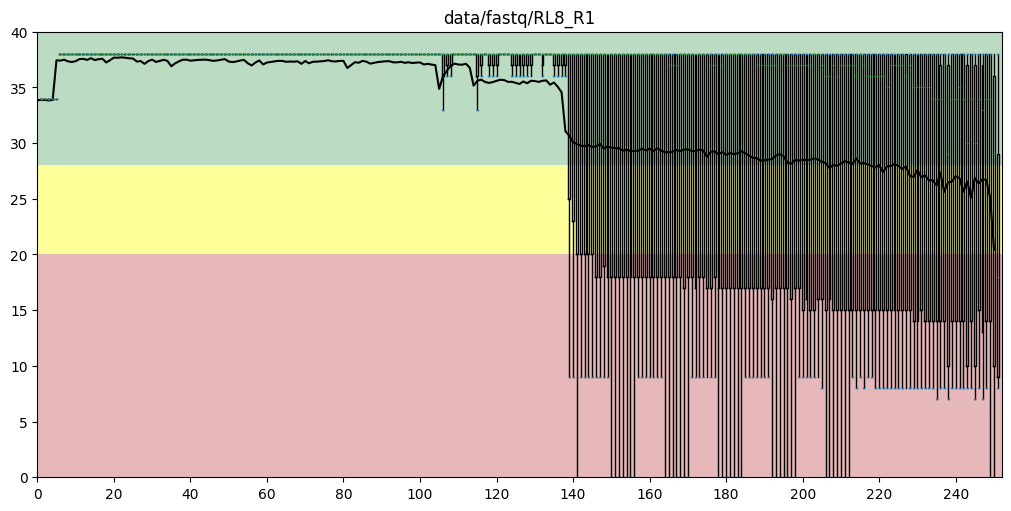

In [494]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5), layout='constrained')#plt.subplots(4, 2, figsize=(20, 20))
filename = f"data/fastq/RL8_R1_001.fastq"

fastq_parser = SeqIO.parse(filename, "fastq")
res=[]

for record in fastq_parser:
    score=record.letter_annotations["phred_quality"]
    res.append(score)
df = pd.DataFrame(res)
l = len(df.T)+1

ax = axs

rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
ax.add_patch(rect)
df.mean().plot(ax=ax,c='black')
boxprops = dict(linestyle='-', linewidth=1, color='black')
df.plot(kind='box', ax=ax, grid=False, showfliers=False,
        color=dict(boxes='black',whiskers='black')  )
ax.set_xticks(np.arange(0, l, 20))
ax.set_xticklabels(np.arange(0, l,20))

ax.set_xlim((0,l))
ax.set_ylim((0,40))
ax.set_title(filename.split(".")[0][:-4])
plt.savefig(f"{FigFolder}/R1_quality_scores.pdf", bbox_inches="tight")
plt.show()


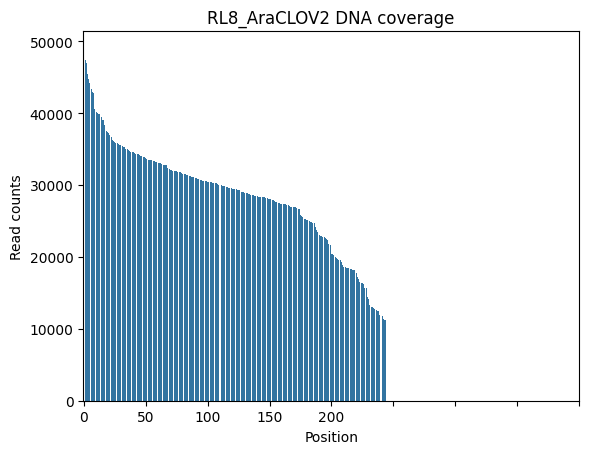

In [540]:
## plot coverage 
plt.rcdefaults()
coverage_plot(seq_variants["DNA"].sum(), variant_name=variant, FigFolder=FigFolder)



In [477]:
DNA_variants_roi.shape[1]//3

58

In [542]:
region_of_interest ="TTAGCCACAAC"
start_region_of_interest = amplicon_DNA_seq.index(region_of_interest) if region_of_interest else 0
DNA_variants_roi = seq_variants["DNA"].iloc[:,start_region_of_interest:]
AA_variants_roi = seq_variants["AA"].iloc[:,start_region_of_interest//3:]
Codon_variants_roi = seq_variants["Codons"].iloc[:,start_region_of_interest//3:]


coverage = DNA_variants_roi.sum().sum()/(DNA_variants_roi.max().max()*DNA_variants_roi.shape[1])*100
print(f'The illumina paired reads cover on average {coverage.round(1)} % of the LOV sequence')

mut_rate_AA = AA_variants_roi.max()/AA_variants_roi.sum()-1
mut_rate_AA = abs(mut_rate_AA.sum())
print(f'The mutation rate is estimated to be {mut_rate_AA.round(3)} AA mutations per sequence')
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_AA/coverage*100,3)} AA mutations per sequence')

mut_rate_DNA = DNA_variants_roi.max()/DNA_variants_roi.sum()-1
mut_rate_DNA = abs(mut_rate_DNA.sum())  # this is the mutation rate per nucleotide, based on the number of reads (per nt)
print(f'The mutation rate is estimated to be {mut_rate_DNA.round(3)} DNA mutations per sequence') 
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_DNA/coverage*100,3)} DNA mutations per sequence')

mut_rate_Codons = Codon_variants_roi.max()/Codon_variants_roi.sum()-1
mut_rate_Codons = abs(mut_rate_Codons.sum())
print(f'The mutation rate is estimated to be {mut_rate_Codons.round(3)} Codon mutations per sequence')
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate_Codons/coverage*100,3)} Codon mutations per sequence')

mut_rates_dict = {"variant": name, 
                  "coverage": coverage,
                  "AA_mut_per_sequence": mut_rate_AA,
                  #"AA_mut_per_sequence_coverage_corrected": mut_rate_AA/coverage*100,
                  "DNA_mut_per_sequence": mut_rate_DNA,
                  #"DNA_mut_per_sequence_coverage_corrected": mut_rate_DNA/coverage*100, 
                  "Codon_mut_per_sequence": mut_rate_Codons,
                  #"Codon_mut_per_sequence_coverage_corrected": mut_rate_Codons/coverage*100
                  }
if FigFolder: 
    with open(f'{FigFolder}/{name}_mutation_rates.json', 'w') as file:
        file.write(json.dumps(mut_rates_dict, indent=4))

The illumina paired reads cover on average 79.0 % of the LOV sequence
The mutation rate is estimated to be 0.334 AA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 0.423 AA mutations per sequence
The mutation rate is estimated to be 0.781 DNA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 0.988 DNA mutations per sequence
The mutation rate is estimated to be 0.353 Codon mutations per sequence
If we correct for the coverage, we expect a mutation rate of 0.447 Codon mutations per sequence


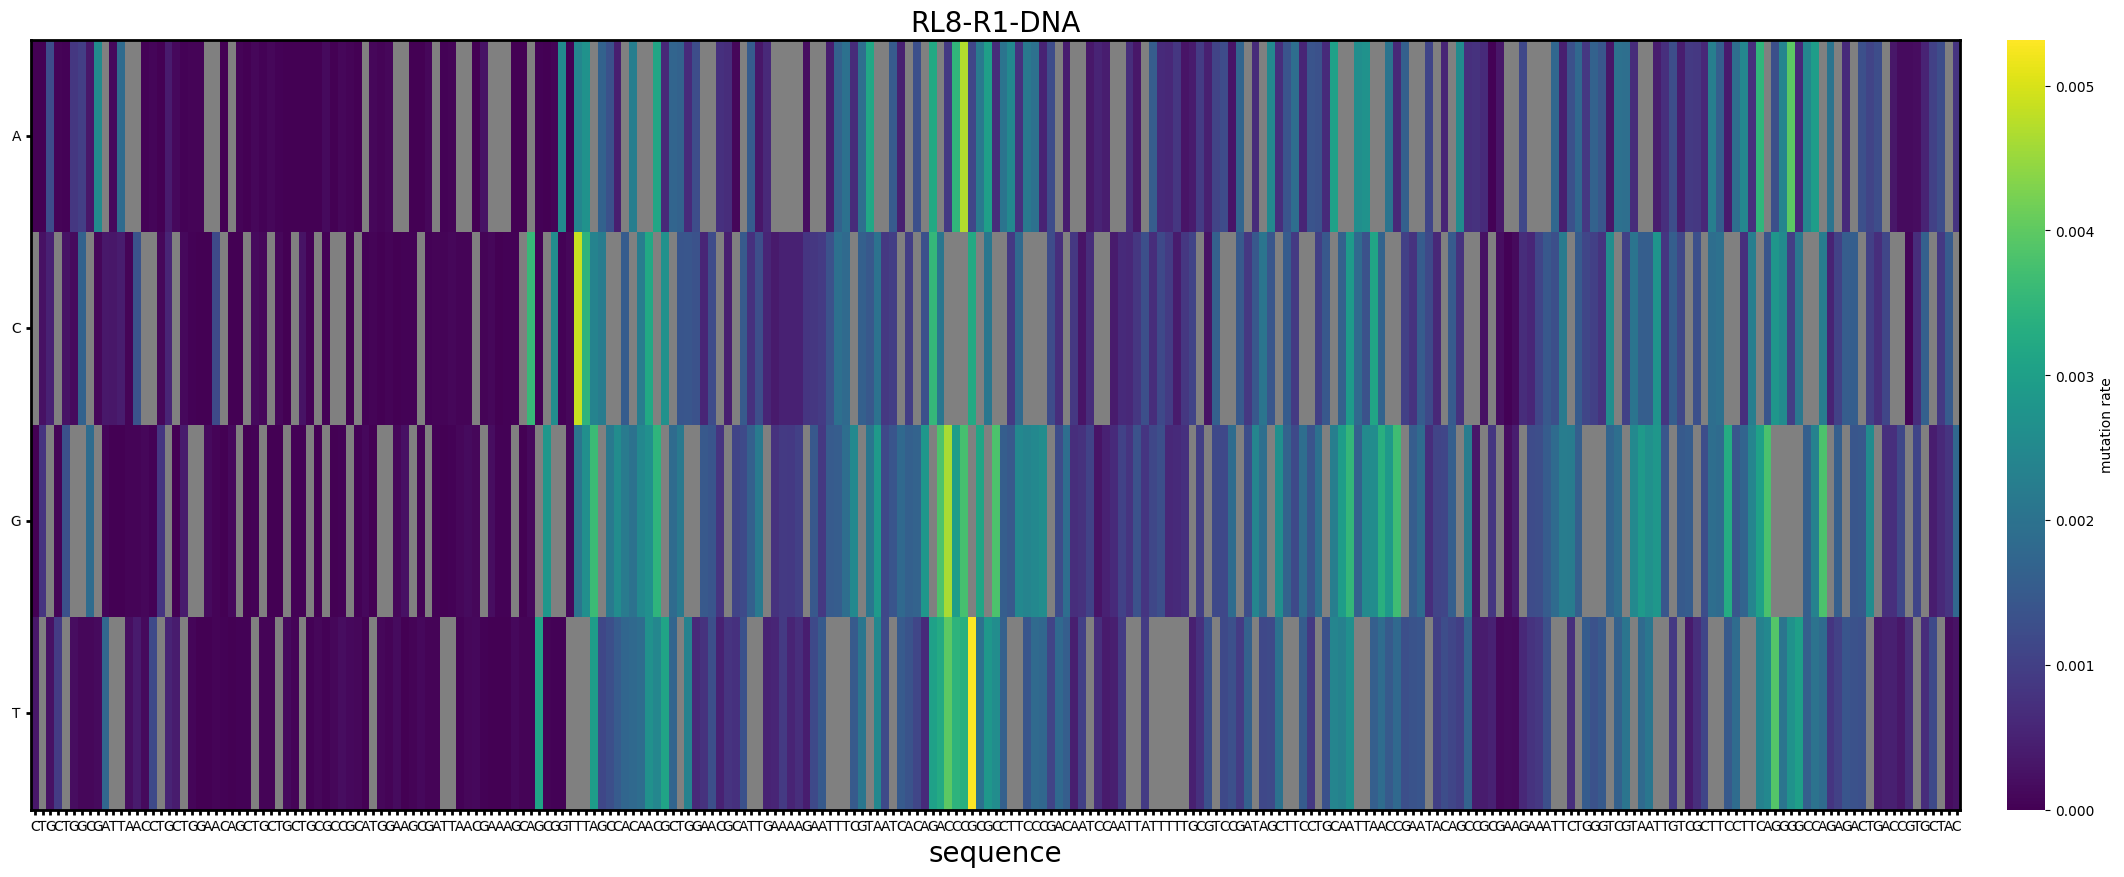

<Figure size 640x480 with 0 Axes>

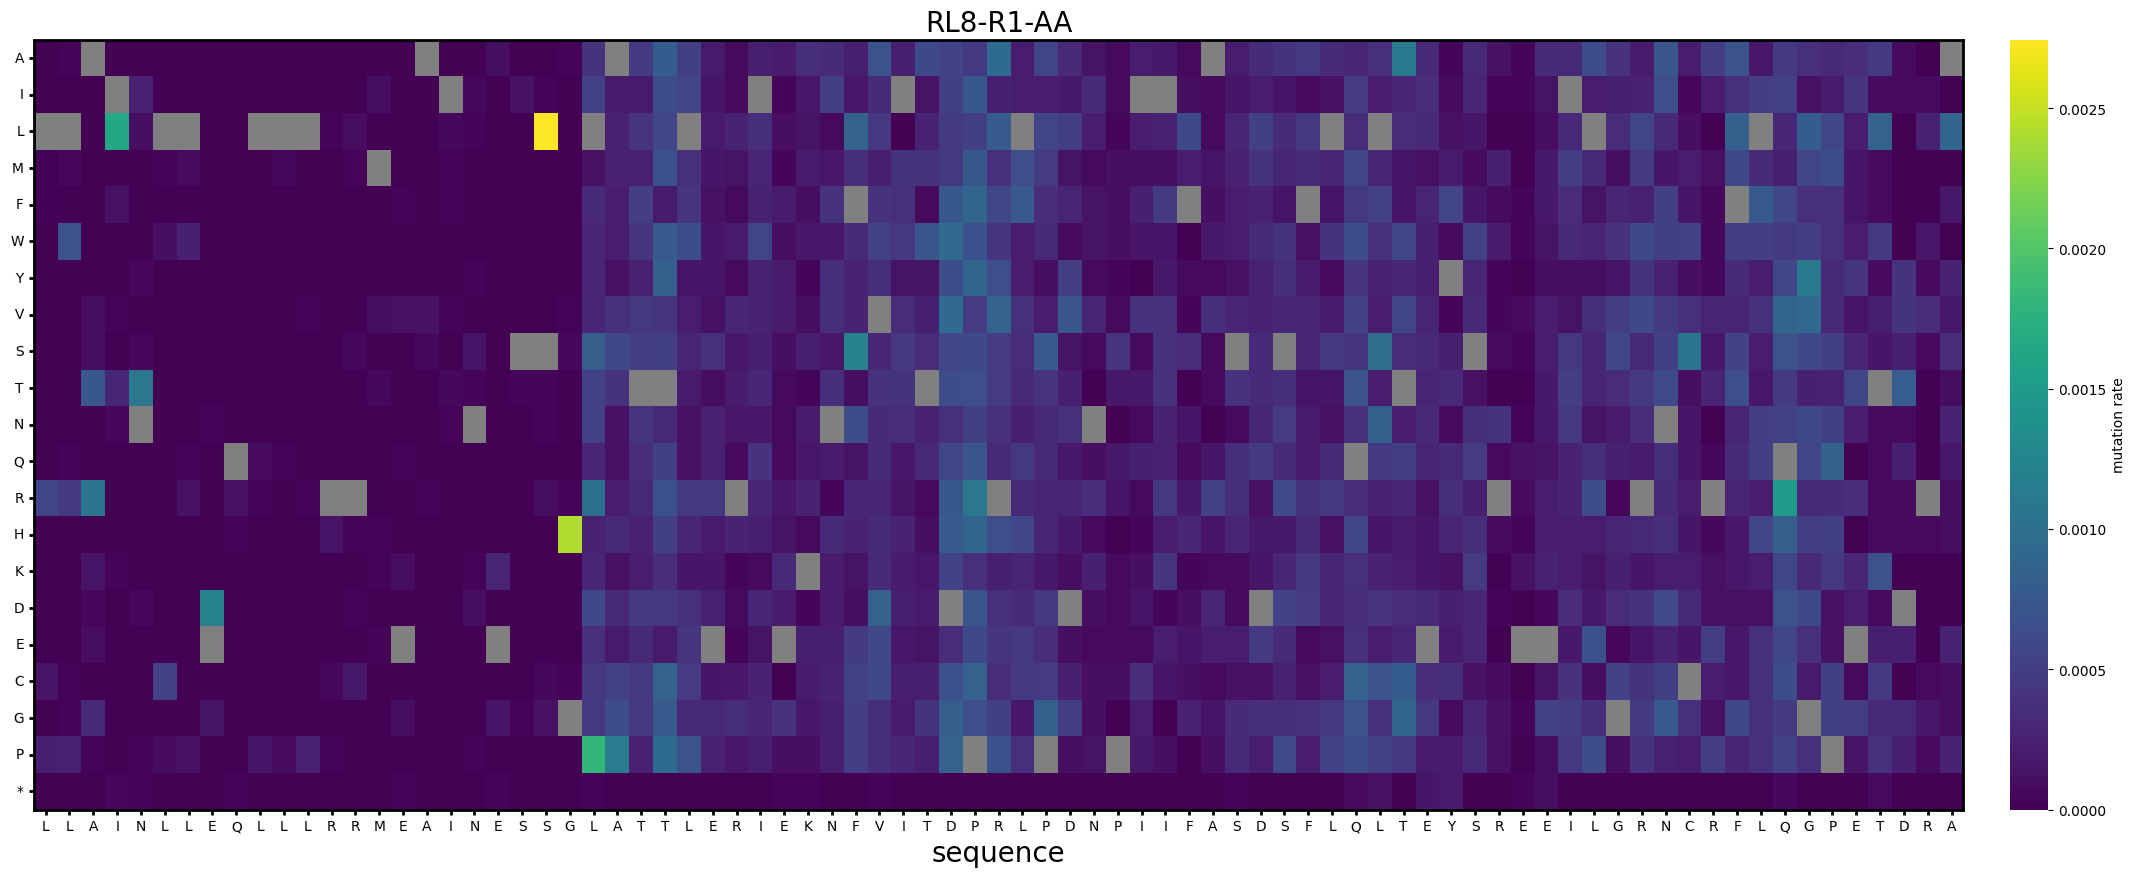

<Figure size 640x480 with 0 Axes>

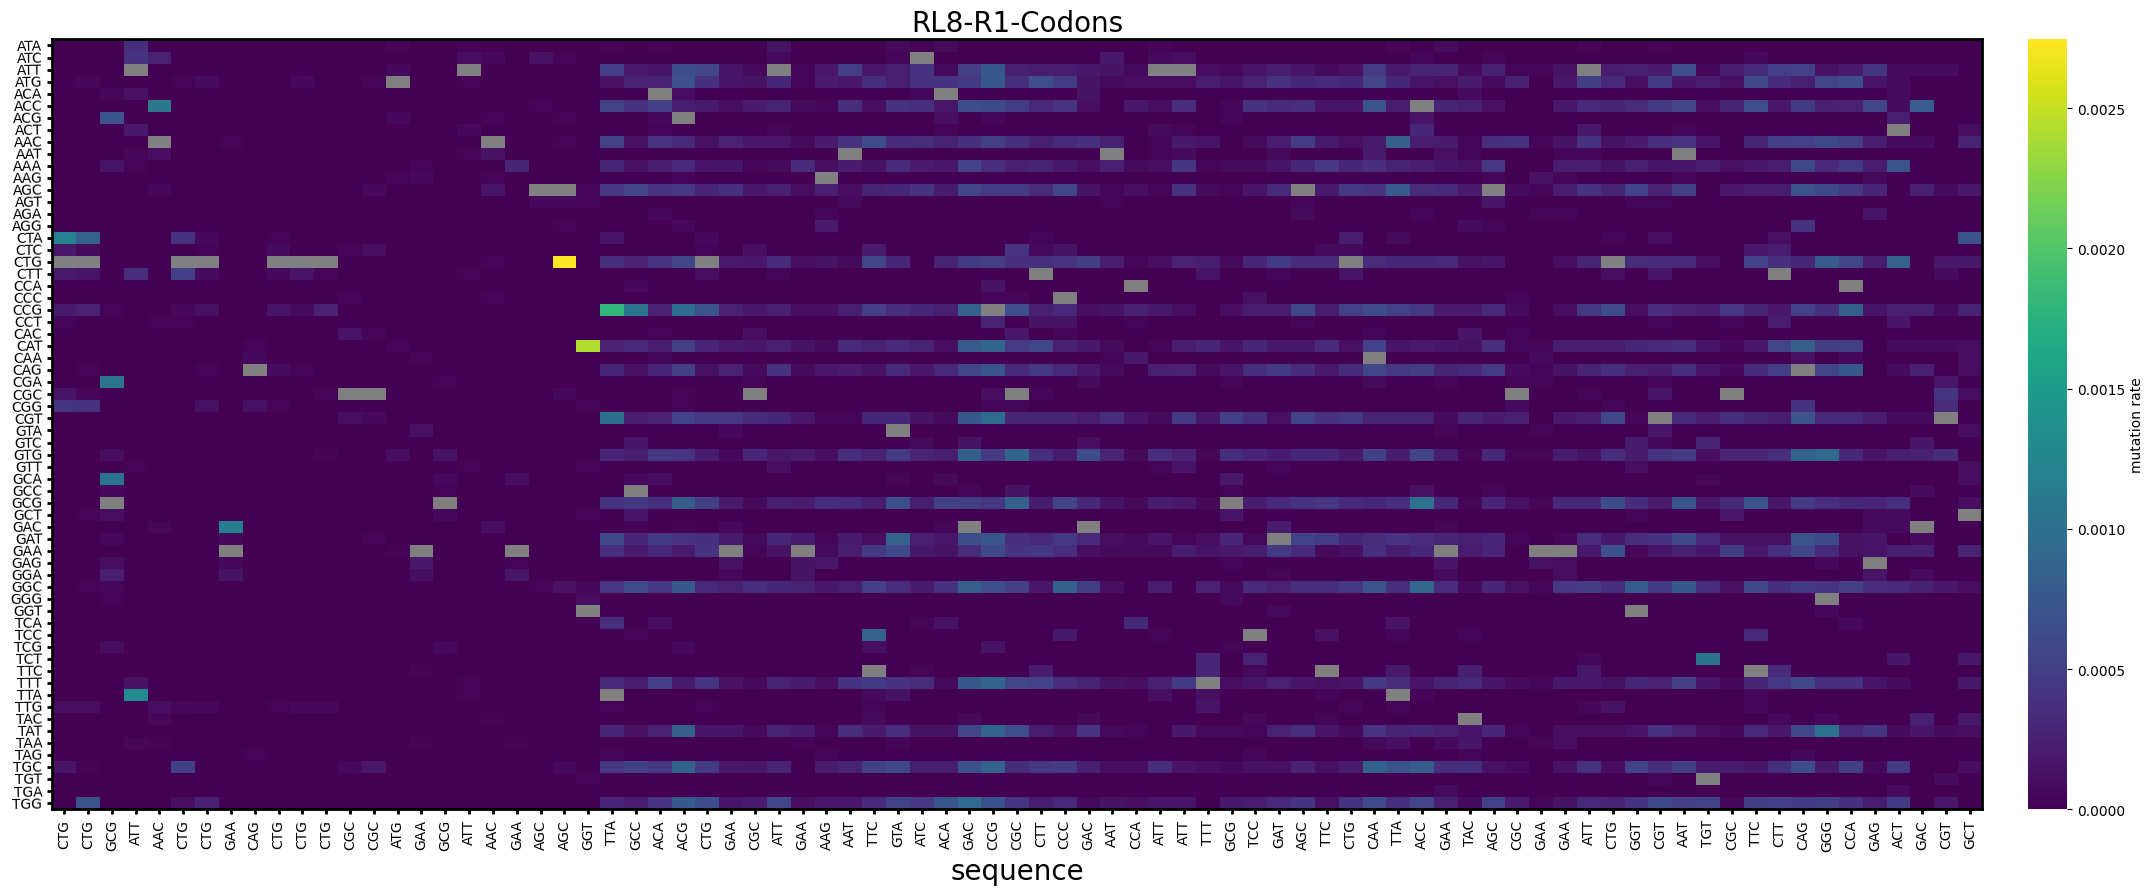

<Figure size 640x480 with 0 Axes>

In [8]:
## plot mutation enrichment on DNA, AA and Codon level 
DNA_relative = seq_variants['DNA']/seq_variants['DNA'].sum()
if not use_forward_read: 
    DNA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(DNA_relative, name =  f'{name}-DNA', reverse= not use_forward_read, data_type = "DNA", ref_seq=amplicon_DNA, fig_folder=FigFolder)

AA_relative = seq_variants['AA']/seq_variants['AA'].sum()
if not use_forward_read:
    AA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(AA_relative, f'{name}-AA',ref_seq=amplicon_AA,data_type = "AA", reverse = not use_forward_read, fig_folder=FigFolder)

Codons_relative = seq_variants['Codons']/seq_variants['Codons'].sum()
if not use_forward_read:
    Codons_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(Codons_relative, f'{name}-Codons',ref_seq=amplicon_DNA,data_type = "Codons", reverse = not use_forward_read, fig_folder=FigFolder)


In [476]:
## mut rates per position for LOV2 sequence of R1
Codon_mut_rate_per_pos[69//3:].to_csv(f"{FigFolder}/{name}_Codon_mut_rate_per_pos.csv")

In [20]:
FigFolder

'/Users/annavonbachmann/Documents/GitHub/DMS_analysis/output/RL8_AraCLOV2/R1'

<Figure size 640x480 with 0 Axes>

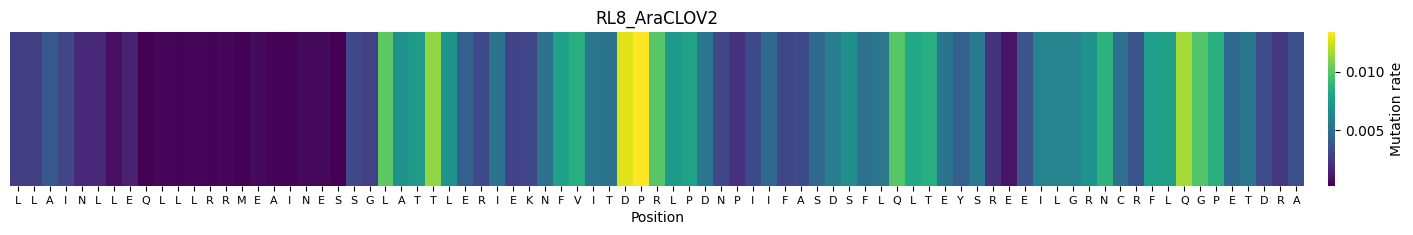

<Figure size 640x480 with 0 Axes>

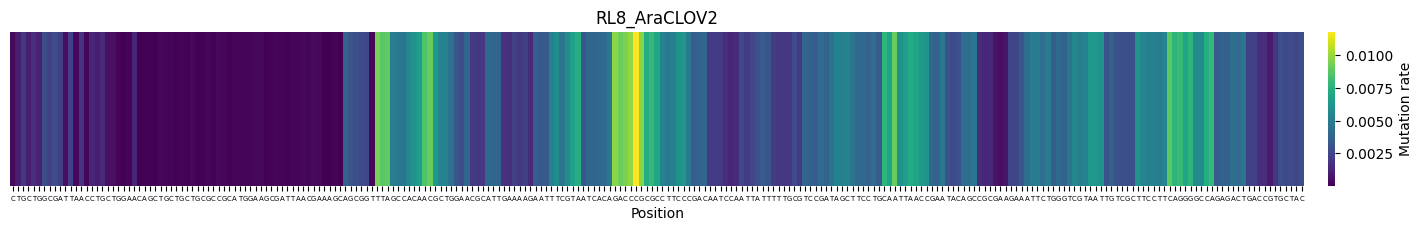

<Figure size 640x480 with 0 Axes>

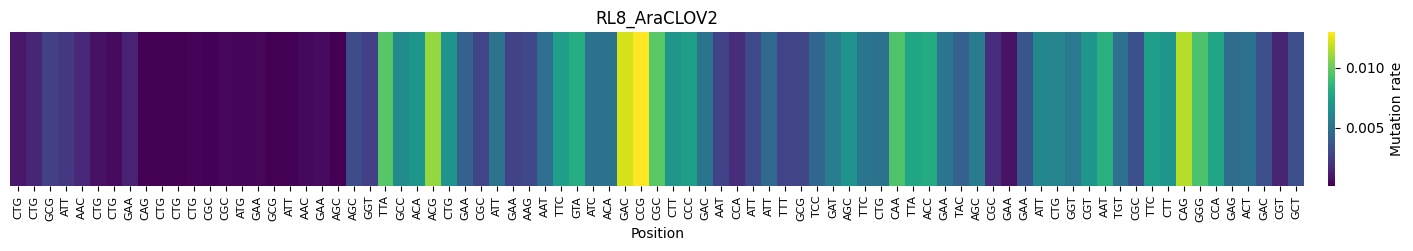

In [33]:
## plot mutation rate per position 
DNA_mut_rate_per_pos = (seq_variants["DNA"].sum()-seq_variants["DNA"].max())/seq_variants["DNA"].sum()

# plot_mut_rate_per_pos(DNA_mut_rate_per_pos, variant_name = variant, FigFolder = FigFolder, ref_seq=amplicon_DNA)

Codon_mut_rate_per_pos = (seq_variants["Codons"].sum()-seq_variants["Codons"].max())/seq_variants["Codons"].sum()
AA_mut_rate_per_pos = (seq_variants["AA"].sum()-seq_variants["AA"].max())/seq_variants["AA"].sum()
LOV_codons = [amplicon_DNA[i:i+3] for i in range(0, len(Codon_mut_rate_per_pos)*3, 3)]
amplicon_AAs = [aa for aa in amplicon_AA[:len(Codon_mut_rate_per_pos)]]


plt.figure(figsize=(20,2))
sns.heatmap(pd.DataFrame(Codon_mut_rate_per_pos).T, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.015, "label": "Mutation rate" },linecolor="black", xticklabels=amplicon_AAs, yticklabels=False)
plt.xlabel("Position")
plt.xticks(fontsize=8)
plt.title(name)
plt.savefig(f"{FigFolder}/{name}_mutation_rate_per_Codon_position.pdf", bbox_inches = "tight")
plt.show()
plt.clf()

plt.figure(figsize=(20,2))
sns.heatmap(pd.DataFrame(DNA_mut_rate_per_pos).T, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.015, "label": "Mutation rate" },linecolor="black", xticklabels=amplicon_DNA_seq[:len(DNA_mut_rate_per_pos)], yticklabels=False)
plt.xlabel("Position")
plt.xticks(fontsize=5, rotation = 1)
plt.title(name)
plt.savefig(f"{FigFolder}/{name}_mutation_rate_per_Nt_position.pdf", bbox_inches = "tight")
plt.show()
plt.clf()

plt.figure(figsize=(20,2))
sns.heatmap(pd.DataFrame(AA_mut_rate_per_pos).T, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.015, "label": "Mutation rate" },linecolor="black", xticklabels=LOV_codons, yticklabels=False)
plt.xlabel("Position")
plt.xticks(fontsize=8)
plt.title(name)
plt.savefig(f"{FigFolder}/{name}_mutation_rate_per_AA_position.pdf", bbox_inches = "tight")
plt.show()
plt.clf()

In [164]:
### calculate number of base changes per position to all intended changes 
LOV_gene_codons = LOV_codons[amplicon_AA_seq.index("LATTLER"):]
pref_codons = list(ecoli_pref.values())
base_differences = []
for LOV_codon in LOV_gene_codons: 
    diff = []
    for pref_cod in pref_codons: 
        base_diff = sum([LOV_codon[i] != pref_cod[i] for i in range(0,3)])
        diff.append(base_diff)
    base_differences.append(diff)

## mean
mean_base_diff = [np.mean(diff) for diff in base_differences]

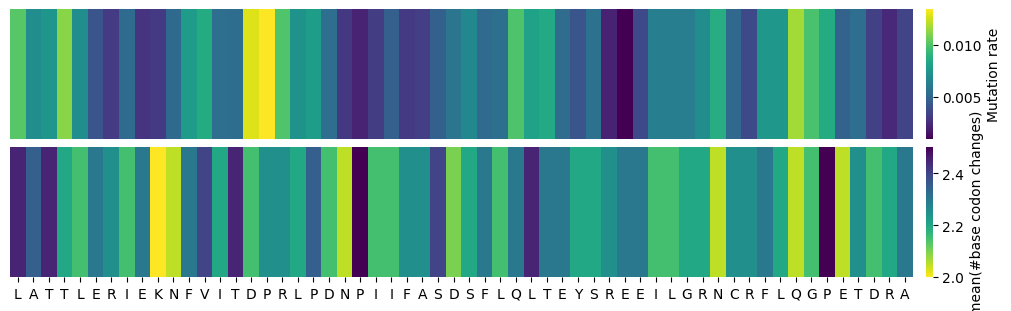

In [166]:
fig,ax = plt.subplots(2,1,figsize=(10,3), layout = 'constrained')
sns.heatmap(pd.DataFrame(Codon_mut_rate_per_pos[amplicon_AA_seq.index("LATTLER"):]).T, ax = ax[0], xticklabels = False, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.015, "label": "Mutation rate" },linecolor="black", yticklabels=False)
sns.heatmap(pd.DataFrame(mean_base_diff).T, ax = ax[1], cmap = "viridis_r", cbar = True, cbar_kws = {"pad": 0.015, "label": "mean(#base codon changes)" },linecolor="black", yticklabels=False, xticklabels = amplicon_AA_seq[amplicon_AA_seq.index("LATTLER"):len(Codon_mut_rate_per_pos)])
plt.show()

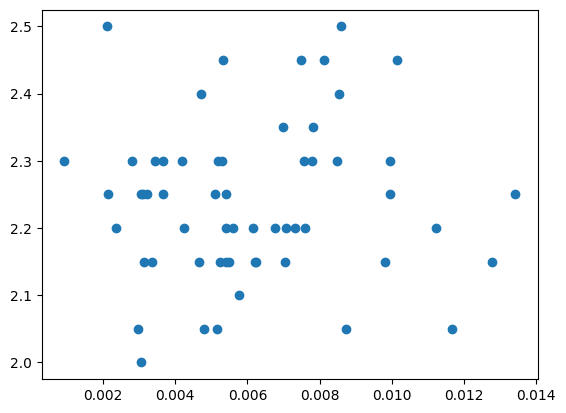

In [167]:
plt.scatter(Codon_mut_rate_per_pos[amplicon_AA_seq.index("LATTLER"):], mean_base_diff)
plt.show()

In [119]:
## ViennaRNA package for DNA

###### RNAfold -i AraC_S170_LOV_DMS_Retron_Pool.fasta --noconv --param=DNA -oviennaRNAfoldAraC_S170_LOV_DMS_Retron_Pool
###### grep -Eo "[-]?[0-9]+\.[0-9]+" viennaRNAfoldAraC_S170_LOV_DMS_Retron_Pool > viennaRNAfoldAraC_S170_LOV_DMS_Retron_Pool_delta_g_values.txt 
delta_gs = pd.read_csv("data/ViennaRNAFold/viennaRNAfoldAraC_S170_LOV_DMS_Retron_Pool_delta_g_values.txt", header = None).T
## calculate mean of folding energies per position
mean_dGs = []
pos = 0
for i in range(0, delta_gs.shape[1], 20):
        mean_dGs.append(np.mean(delta_gs.iloc[:,i:i+20]))
        pos += 3
## pos = 423 = len(LOV2) -> quality ctrl 

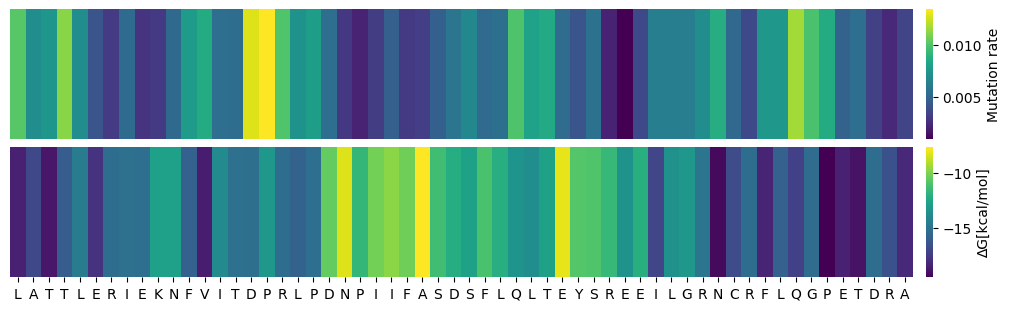

In [124]:
fig,ax = plt.subplots(2,1,figsize=(10,3), layout = 'constrained')
sns.heatmap(pd.DataFrame(Codon_mut_rate_per_pos[amplicon_AA_seq.index("LATTLER"):]).T, ax = ax[0], xticklabels = False, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.015, "label": "Mutation rate" },linecolor="black", yticklabels=False)
sns.heatmap(pd.DataFrame(mean_dGs[:len(Codon_mut_rate_per_pos[amplicon_AA_seq.index("LATTLER"):])]).T, ax = ax[1], cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.015, "label": "∆G[kcal/mol]" },linecolor="black", yticklabels=False, xticklabels = amplicon_AA_seq[amplicon_AA_seq.index("LATTLER"):len(Codon_mut_rate_per_pos)])
plt.show()

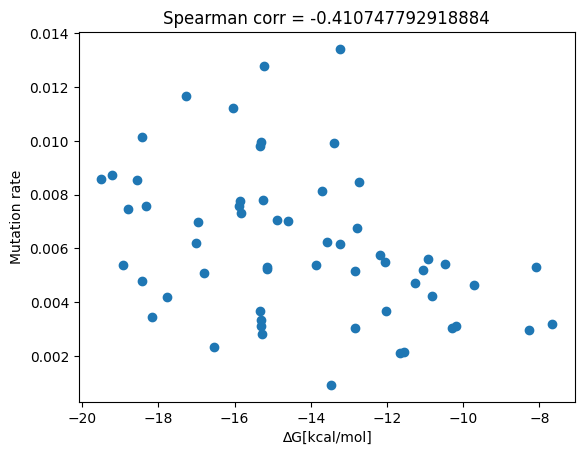

In [168]:
plt.scatter(mean_dGs[:len(Codon_mut_rate_per_pos[amplicon_AA_seq.index("LATTLER"):])], Codon_mut_rate_per_pos[amplicon_AA_seq.index("LATTLER"):])
plt.ylabel("Mutation rate")
plt.xlabel("∆G[kcal/mol]")
plt.title(f'Spearman corr = {scipy.stats.spearmanr(Codon_mut_rate_per_pos[amplicon_AA_seq.index("LATTLER"):],mean_dGs[:len(Codon_mut_rate_per_pos[amplicon_AA_seq.index("LATTLER"):])])[0]}')
plt.show()

In [169]:
scipy.stats.spearmanr(mean_dGs[:len(Codon_mut_rate_per_pos[amplicon_AA_seq.index("LATTLER"):])],Codon_mut_rate_per_pos[amplicon_AA_seq.index("LATTLER"):])

SignificanceResult(statistic=np.float64(-0.410747792918884), pvalue=np.float64(0.0013615307518445223))

In [68]:
Codon_mut_rate_per_pos[amplicon_AA_seq.index("LATTLER"):]

23    0.010144
24    0.006989
25    0.007480
26    0.011210
27    0.007034
28    0.004199
29    0.003122
30    0.005246
31    0.002807
32    0.003043
33    0.005164
34    0.007778
35    0.008549
36    0.005394
37    0.005319
38    0.012771
39    0.013416
40    0.009954
41    0.007307
42    0.007812
43    0.005404
44    0.002957
45    0.002099
46    0.003134
47    0.004657
48    0.003040
49    0.003207
50    0.004725
51    0.005764
52    0.006771
53    0.005189
54    0.005479
55    0.009935
56    0.008135
57    0.008470
58    0.005303
59    0.004241
60    0.005594
61    0.002146
62    0.000928
63    0.003663
64    0.006201
65    0.006234
66    0.006160
67    0.007063
68    0.008724
69    0.005091
70    0.003675
71    0.007563
72    0.007596
73    0.011662
74    0.009815
75    0.008582
76    0.004785
77    0.005395
78    0.003344
79    0.002353
80    0.003444
dtype: float64

In [546]:
## calculate and plot the number of Nt and Codon mutations per sequence

a_seq, b_seq = read_sequences(variant, catch_left=catch_left, catch_right=catch_right)
seq_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = amplicon_DNA, use_rev_read=use_rev_read, use_triplets=False)
seq_n_Nt_mutations = dict(sorted(seq_n_Nt_mutations.items())) ## sort dictionary after key

seq_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = amplicon_DNA, use_rev_read=use_rev_read, use_triplets=True)
seq_n_Codon_mutations = dict(sorted(seq_n_Codon_mutations.items())) ## sort dictionary after key

print("Nt mutations", seq_n_Nt_mutations)
print("Codon mutations", seq_n_Codon_mutations)

total reads 106362
Nt mutations {0: 87964, 1: 1972, 2: 2740, 3: 3046, 4: 337, 5: 262, 6: 170, 7: 60, 8: 43, 9: 37, 10: 57, 11: 31, 12: 49, 13: 60, 14: 31, 15: 23, 16: 21, 17: 28, 18: 27, 19: 36, 20: 23, 21: 21, 22: 52, 23: 19, 24: 30, 25: 15, 26: 26, 27: 64, 28: 25, 29: 127, 30: 30, 31: 31, 32: 24, 33: 37, 34: 23, 35: 74, 36: 40, 37: 27, 38: 34, 39: 86, 40: 36, 41: 102, 42: 45, 43: 61, 44: 31, 45: 22, 46: 64, 47: 28, 48: 24, 49: 39, 50: 40, 51: 53, 52: 35, 53: 26, 54: 42, 55: 22, 56: 31, 57: 30, 58: 21, 59: 30, 60: 26, 61: 24, 62: 22, 63: 45, 64: 31, 65: 29, 66: 56, 67: 46, 68: 39, 69: 30, 70: 39, 71: 31, 72: 15, 73: 72, 74: 31, 75: 28, 76: 38, 77: 27, 78: 28, 79: 29, 80: 26, 81: 41, 82: 27, 83: 35, 84: 28, 85: 24, 86: 25, 87: 32, 88: 41, 89: 41, 90: 61, 91: 83, 92: 71, 93: 51, 94: 55, 95: 194, 96: 389, 97: 2238, 98: 71, 99: 34, 100: 21, 101: 34, 102: 24, 103: 20, 104: 35, 105: 79, 106: 65, 107: 24, 108: 40, 109: 22, 110: 27, 111: 89, 112: 51, 113: 305, 114: 160, 115: 56, 116: 48, 117:

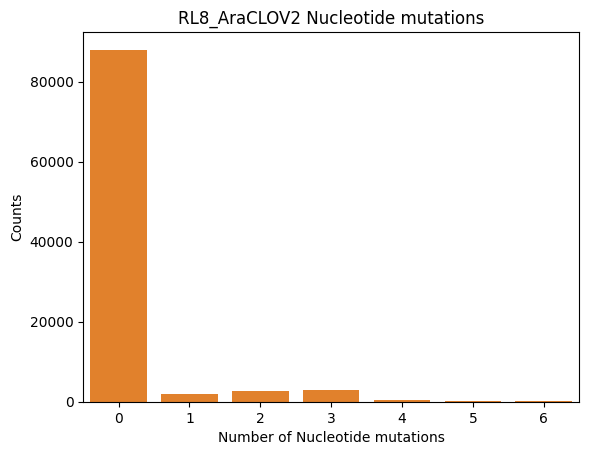

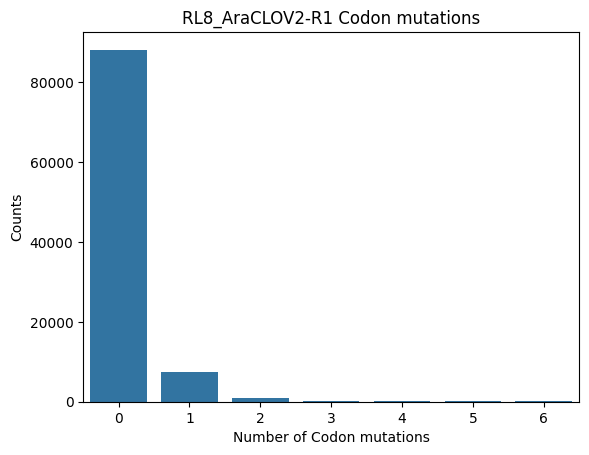

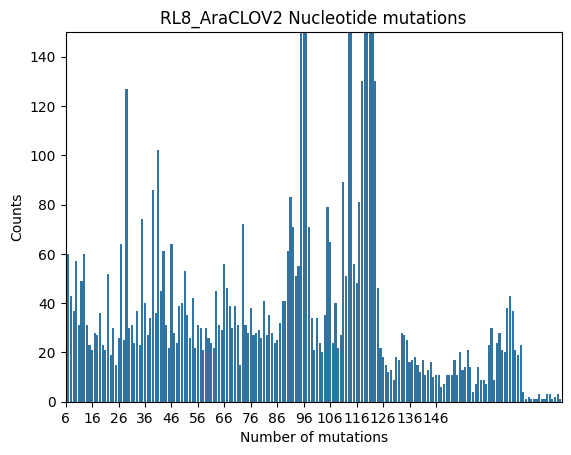

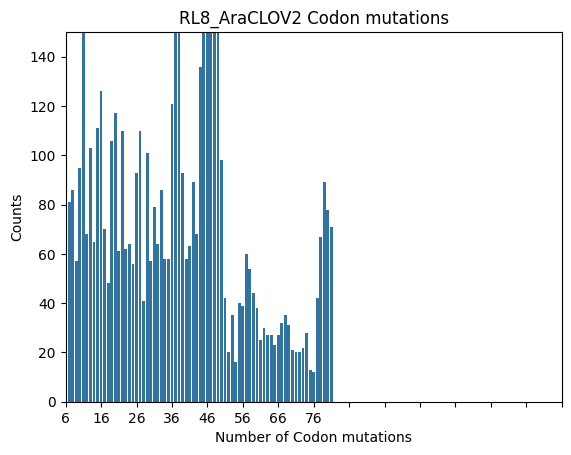

In [27]:
## plot number of Nt mutations

sns.barplot(seq_n_Nt_mutations)
plt.xlim(-0.5,6.5)
plt.xlabel('Number of Nucleotide mutations')
plt.ylabel('Counts')
plt.title(f'{name} Nucleotide mutations')
# plt.savefig(f'figures/{name}_n_Nt_mutations_per_read.pdf')
plt.show()

sns.barplot(seq_n_Codon_mutations)
plt.xlim(-0.5,6.5)
plt.xlabel('Number of Codon mutations')
plt.ylabel('Counts')
plt.title(f'{variant}-R1 Codon mutations')
# plt.savefig(f'figures/{name}_n_Codon_mutations_per_read.pdf')
plt.show()

plt.clf()
sns.barplot(seq_n_Nt_mutations)
plt.xlim(6.5)
plt.xticks(list(range(6, 150, 10)))
plt.ylim(0,150)
plt.xlabel('Number of mutations')
plt.ylabel('Counts')
plt.title(f'{name} Nucleotide mutations')
# plt.savefig(f'figures/{name}_n_Codon_frameshift_mutations_per_read.pdf')
plt.show()
plt.clf()

sns.barplot(seq_n_Codon_mutations)
plt.xlim(6.5)
plt.xticks(list(range(6, 150, 10)))
plt.ylim(0,150)
plt.xlabel('Number of Codon mutations')
plt.ylabel('Counts')
plt.title(f'{name} Codon mutations')
# plt.savefig(f'figures/{name}_n_Nt_frameshift_mutations_per_read.pdf')
plt.show()

In [ ]:
# # calculate the mutation rate (!! different to before, here, we calculate the mutation rate per read, not per nt (i.e. we divide by the number of total reads, not the reads for each nt respectively!! --> perhaps inaccurate due to low coverage of some nts)
# total_reads = sum(seq_n_mutations.values())
# total_mutations = sum([key*value for key, value in seq_n_mutations.items()])
# mutation_rate = total_mutations/total_reads
# print(mutation_rate)

In [551]:
# mutagenic spectrum
variant = "RL8_AraCLOV2"
a_seq, b_seq = read_sequences(variant, catch_left=catch_left, catch_right=catch_right)
a_seq, b_seq = read_filtering(a_seq, b_seq, n_mut_treshold = n_mut_treshold, ref_gene=amplicon_DNA, catch_left=catch_left, catch_right = catch_right)

n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum(a_seq, b_seq, reference_seq = amplicon_DNA, use_rev_read=use_rev_read, use_forward_read=use_forward_read)

n_mut_spectrum_perc_df = pd.DataFrame.from_dict(n_mut_spectrum_perc, orient='index')
n_mut_spectrum_df = pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")

print(n_mut_spectrum_df)
print(n_mut_spectrum_perc_df)

np.fill_diagonal(n_mut_spectrum_perc_df.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)
np.fill_diagonal(n_mut_spectrum_df.values, np.nan)


total reads 106362
total forward reads before filtering 98927
total reverse reads before filtering 65570
total forward reads after filtering 49839
total reverse reads after filtering 52854
          A         C         G         T
A       0.0  308602.0  180737.0  419704.0
C  304943.0       0.0  296151.0  305948.0
G  388478.0  323731.0       0.0  122649.0
T  268468.0  284894.0  175051.0       0.0
        A      C      G       T
A   0.000  9.132  5.348  12.420
C   9.024  0.000  8.764   9.053
G  11.496  9.580  0.000   3.629
T   7.944  8.430  5.180   0.000


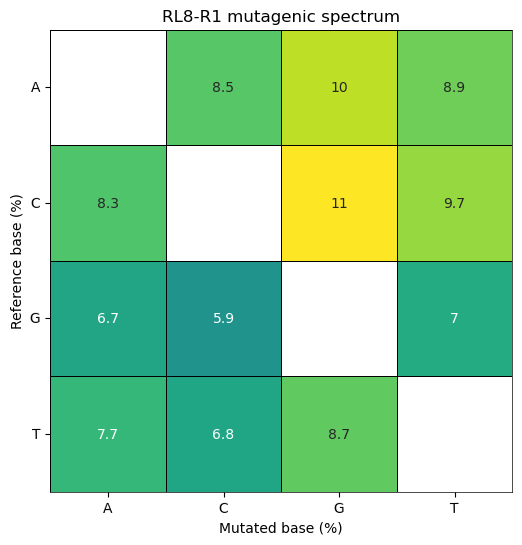

In [758]:
plot_mutation_spectrum(n_mut_spectrum_perc_df, name, fig_folder = FigFolder)

In [552]:
mut_spec_codons, mut_spectrum_codons_perc =  mut_spectrum_codons(a_seq, b_seq, reference_seq = amplicon_DNA, use_rev_read = use_rev_read, use_forward_read = use_forward_read, codon_list = codons, catch_left=catch_left, catch_right=catch_right)
mut_spectrum_codons_perc_df = pd.DataFrame.from_dict(mut_spectrum_codons_perc, orient='index')
np.fill_diagonal(mut_spectrum_codons_perc_df.values, np.nan)

In [553]:
mut_spectrum_codons_df = pd.DataFrame.from_dict(mut_spec_codons, orient='index')
mut_spectrum_codons_df.sum().sum()

np.int64(10149)

In [554]:
from collections import Counter

In [556]:
## filtering of mutagenic spectrum for plotting 
ref_len = len(seq_variants["DNA"].columns)
ref_codons = [amplicon_DNA[i:i+3] for i in range(0,ref_len, 3)]
pref_codons = sorted(ecoli_pref.values())

roi_start = "TTAGCCACA" ############!!!!!

## order the mutagenic spectrum according to the pref codons and filter for the reference codons
mut_spec_perc_ordered = pd.concat((mut_spectrum_codons_perc_df.loc[:,pref_codons], mut_spectrum_codons_perc_df.loc[:,[codon for codon in codons if codon not in pref_codons]]),axis = 1)
mut_spec_perc_ordered = mut_spec_perc_ordered.loc[[codon for codon in codons if codon in ref_codons],:]
mut_spec_perc_ordered = mut_spec_perc_ordered.reindex(sorted(mut_spec_perc_ordered.index), axis=0)

## find codons that are included in (non-targeted) AraC but not in (targeted) LOV sequence
## find start position of LOV2 in seq
LOVstart = amplicon_DNA.index(roi_start) if roi_start else 0
AraC_codons = [amplicon_DNA[i:i+3] for i in range(0, LOVstart, 3)] # AraC codons
LOV_codons = [amplicon_DNA[i:i+3] for i in range(LOVstart, ref_len, 3)] # LOV codons
## filter codons that are only in AraC but not LOV2 seq
AraC_spec_codons = [codon for codon in AraC_codons if codon not in LOV_codons]

## count occs 
counter_LOV = Counter(LOV_codons)
for codon in mut_spec_perc_ordered.index:
    if codon not in counter_LOV:
        counter_LOV[codon] = 0
## sort after key
counter_LOV = dict(sorted(counter_LOV.items()))
### annotations: 
col_annot = ["grey" if codon in pref_codons else "lightgrey" for codon in mut_spec_perc_ordered.columns]
row_annot = list(counter_LOV.values())
# convert row_annot to colors of cmap


cmap = plt.get_cmap('Oranges')
norm = plt.Normalize(min(row_annot), max(row_annot))
row_annot = [cmap(norm(value)) for value in row_annot]


<Figure size 640x480 with 0 Axes>

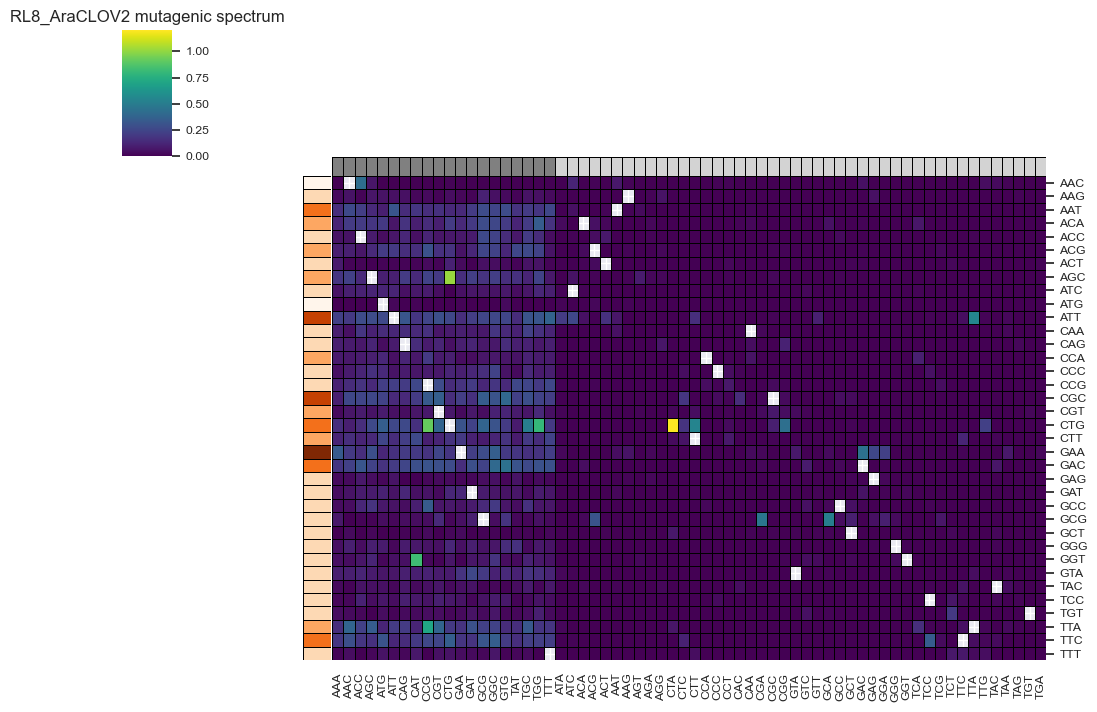

In [557]:

sns.set(font_scale=0.8)
g = sns.clustermap(mut_spec_perc_ordered, annot=False, linewidths=.5,  figsize = (10,7), linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True,col_cluster = False, row_cluster = False,  row_colors=row_annot, col_colors=col_annot, yticklabels = True, vmax = 1.2)

# plt.xlabel('Mutated base (%)', fontsize = 10)
# plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
# for i, tick_label in enumerate(g.get_xticklabels()):
#     if tick_label.get_text() in ecoli_pref.values():
#         tick_label.set_color('red')

# for i, tick_label in enumerate(g.get_yticklabels()):
#     if tick_label.get_text() in AraC_spec_codons:
#         tick_label.set_color('grey')

plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_mutagenic_spectrum_codons_perc_ordered_Annot.pdf")
plt.show()

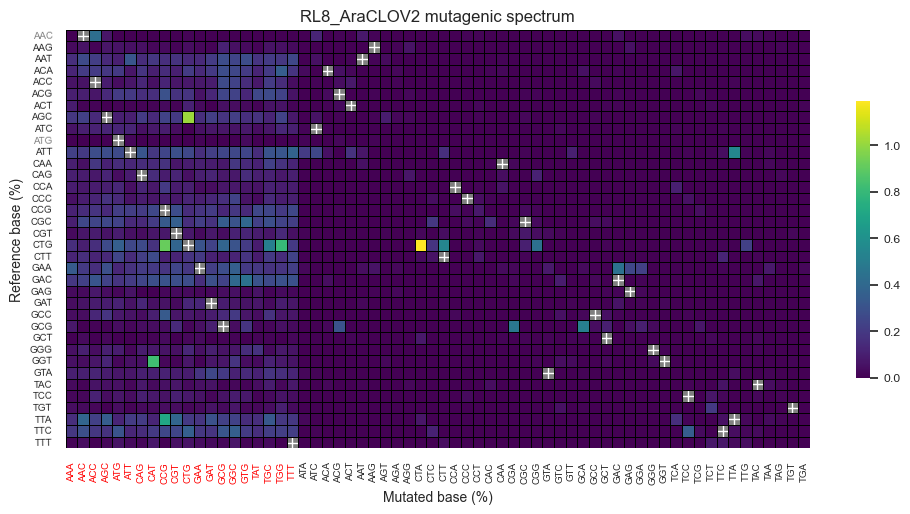

In [558]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(mut_spec_perc_ordered, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True, )
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
ax.set_facecolor('gray')
for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')

for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() in AraC_spec_codons:
        tick_label.set_color('grey')

plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_mutagenic_spectrum_codons_perc_ordered.pdf")
plt.show()

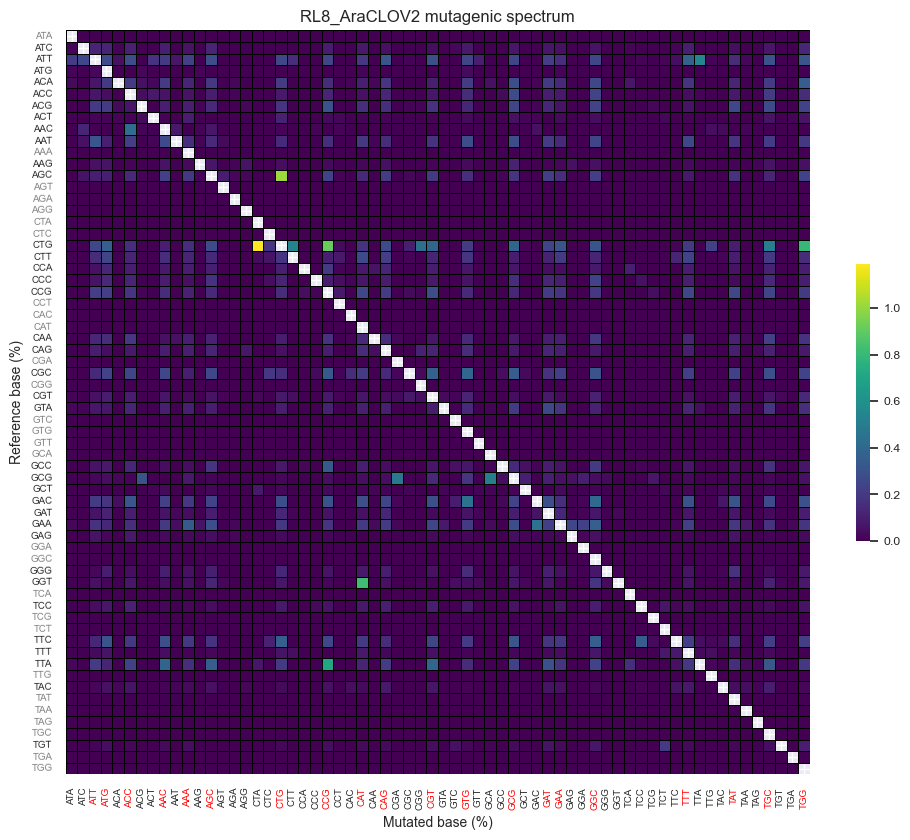

In [559]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(mut_spectrum_codons_perc_df, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')

for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [717]:
### calculate expected mutagenic spectrum for RL8 (--> bias because of chosen Codons for AAs) (for R1 reads only)
## Codon wise
variant = "RL8"
name = "RL8-R1"
a_seq, b_seq = read_sequences(variant)
FigFolder = f"{base_dir}/figures/{name}"
max_len_R1 = max([len(seq) for seq in a_seq])
ref_seq = LOV_gene[:max_len_R1]
ref_codons = [ref_seq[i:i+3] for i in range(0, len(ref_seq)//3*3, 3)]
mut_spec_expected = {"A": {"A":0, "C":0, "G":0, "T":0}, ## {reference nt: {mutated nt: count}}
                    "C" : {"A":0, "C":0, "G":0, "T":0},
                    "G" : {"A":0, "C":0, "G":0, "T":0},
                    "T" : {"A":0, "C":0, "G":0, "T":0}}
for ref_codon in ref_codons:
    for mut_codon in ecoli_pref.values():
        ## calculate mutagenic spectrum for all expected changes per Codon
        for idx in range(3):
            if ref_codon[idx] != mut_codon[idx]:
                mut_spec_expected[ref_codon[idx]][mut_codon[idx]] += 1
        

## calculate mutagenic spectrum in percentage
total_n_muts = sum([sum(value.values()) for value in mut_spec_expected.values()])
mut_spec_expected_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec_expected.items()}
        

total reads 47233


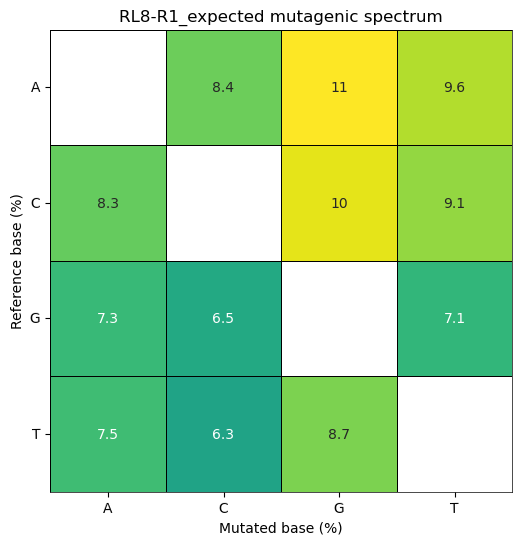

In [457]:
mut_spec_expected_perc_df = pd.DataFrame.from_dict(mut_spec_expected_perc, orient = "index")
np.fill_diagonal(mut_spec_expected_perc_df.values, np.nan)
plot_mutation_spectrum(pd.DataFrame.from_dict(mut_spec_expected_perc_df), samplename = f"{name}_expected", fig_folder = FigFolder)

In [718]:
_, n_mut_spectrum_perc  = mut_spectrum(a_seq, b_seq, reference_seq = LOV_gene, use_rev_read=use_rev_read, use_forward_read=use_forward_read, treshold=10)

n_mut_spectrum_perc_df = pd.DataFrame.from_dict(n_mut_spectrum_perc, orient='index')


np.fill_diagonal(n_mut_spectrum_perc_df.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)

mut_spec_expected_vs_observed = mut_spec_expected_perc_df - n_mut_spectrum_perc_df

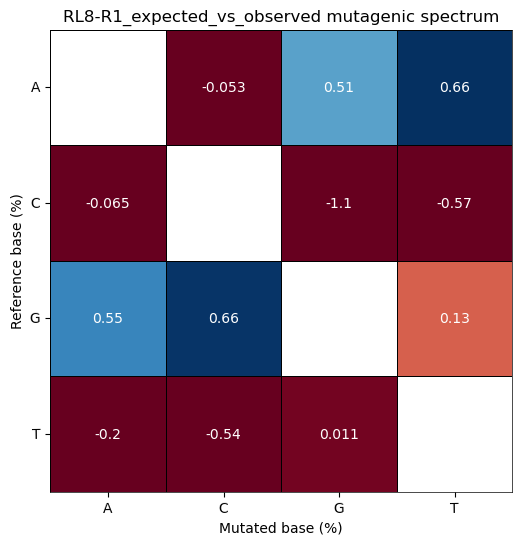

In [719]:
plot_mutation_spectrum(mut_spec_expected_vs_observed, samplename = f"{name}_expected_vs_observed", fig_folder = FigFolder, colormap = "RdBu")

In [720]:
### calculate expected Codon mutagenic spectrum for RL8 (--> bias because of chosen Codons for AAs) (for R1 reads only)

## Codon wise
variant = "RL8"
name = "RL8-R1"
a_seq, b_seq = read_sequences(variant)
FigFolder = f"{base_dir}/figures/{name}"
max_len_R1 = max([len(seq) for seq in a_seq])
ref_seq = LOV_gene[:max_len_R1]
ref_codons = [ref_seq[i:i+3] for i in range(0, len(ref_seq)//3*3, 3)]
codon_list = codons

Codon_mut_spec_expected = {ref_codon: {codon:0 for codon in codon_list} for ref_codon in codon_list} # reference_codon : {mutated_codon: count}

for ref_codon in ref_codons:
    for mut_codon in ecoli_pref.values():
        ## calculate mutagenic spectrum for all expected codons per codon
            if ref_codon != mut_codon:
                Codon_mut_spec_expected[ref_codon][mut_codon] += 1
        

## calculate mutagenic spectrum in percentage
total_n_muts = sum([sum(value.values()) for value in Codon_mut_spec_expected.values()])
Codon_mut_spec_expected_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in Codon_mut_spec_expected.items()}



total reads 47233


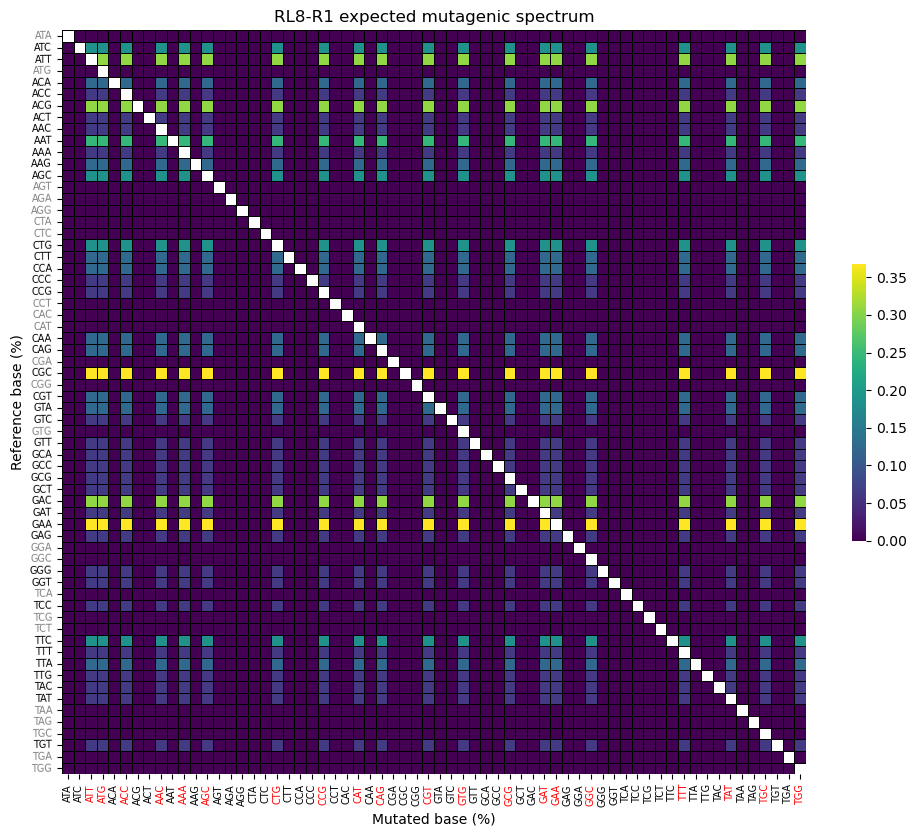

In [722]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(Codon_mut_spec_expected_perc_df, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')

for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

plt.title(f"{name} expected mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_expected_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [723]:
mut_spec_codons, mut_spectrum_codons_perc =  mut_spectrum_codons(a_seq, b_seq, reference_seq = LOV_gene, use_rev_read = False, use_forward_read = True, codon_list = codons, treshold = 6)
mut_spectrum_codons_perc_df = pd.DataFrame.from_dict(mut_spectrum_codons_perc, orient='index')
np.fill_diagonal(mut_spectrum_codons_perc_df.values, np.nan)

mut_spectrum_codons_expected_vs_observed = Codon_mut_spec_expected_perc_df - mut_spectrum_codons_perc_df

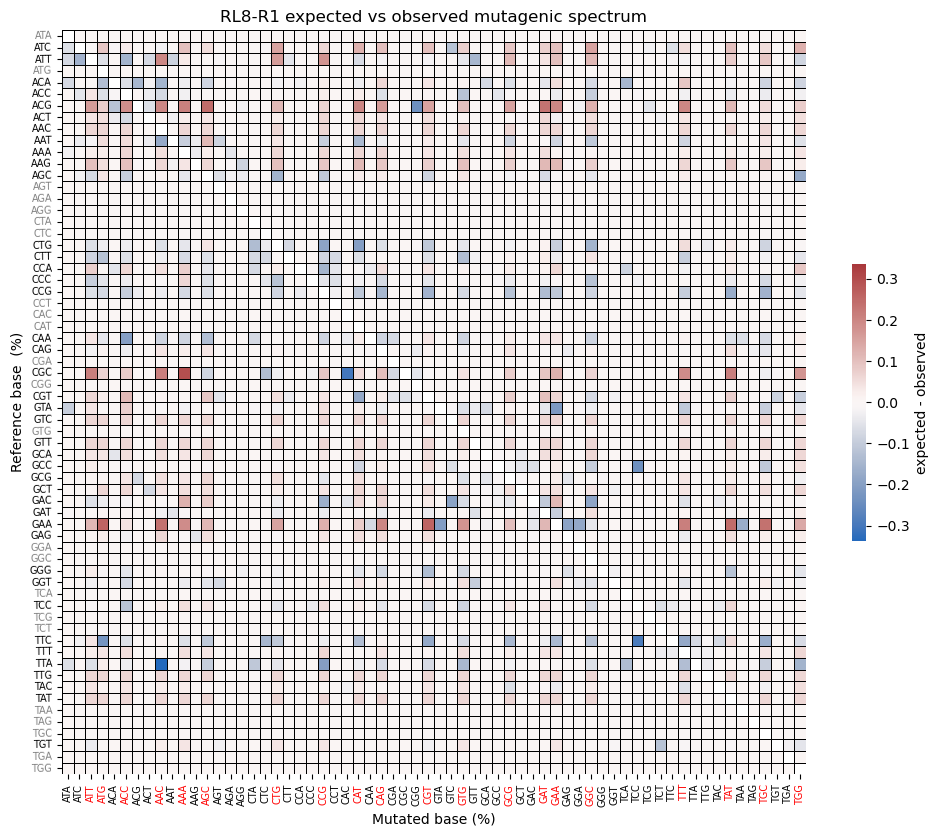

In [725]:
f, ax = plt.subplots(figsize=(12, 12))
cmap_max = np.max(abs(mut_spectrum_codons_expected_vs_observed))
sns.heatmap(mut_spectrum_codons_expected_vs_observed, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "vlag",vmin = -cmap_max, vmax = cmap_max ,cbar_kws={'shrink': 0.3, "label" : "expected - observed"},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base  (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')


for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

plt.title(f"{name} expected vs observed mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_expected_vs_observed_mutagenic_spectrum_codons_perc.pdf")
plt.show()

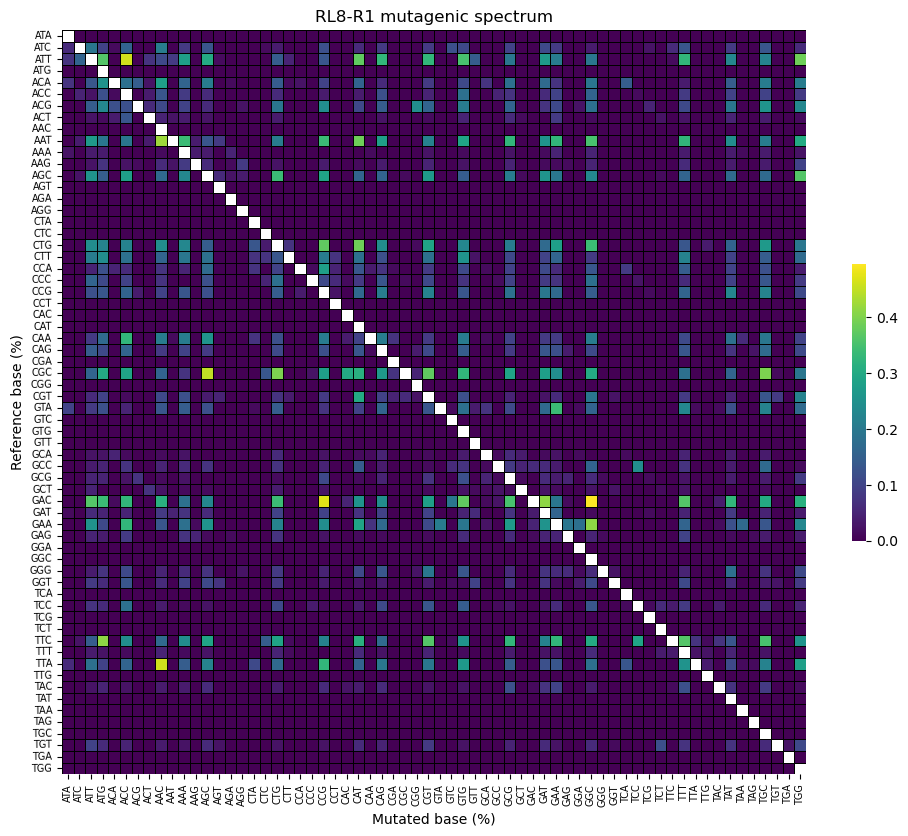

In [726]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(mut_spectrum_codons_perc_df, annot=False, linewidths=.5, ax=ax, vmin = 0, cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

# for i, tick_label in enumerate(ax.get_xticklabels()):
#     if tick_label.get_text() in ecoli_pref.values():
#         tick_label.set_color('red')

plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/{name}_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [560]:
## calculate number of single/double/triple Nt changes codon-wise
Codon_vars = seq_variants["Codons"]
ref_codons = [amplicon_DNA[i:i+3] for i in range(0, Codon_vars.shape[1]*3, 3)]

Nt_changes = {1:0, 2:0, 3:0} # single,double,triple Nt mutations within codons
for pos, mut_Codons in Codon_vars.items(): # iterate columnwise over DF with counts of mutated Codons
    ref_codon = ref_codons[pos]
    for mut_codon in mut_Codons.index:
        if mut_codon != ref_codon: 
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)]) # count number of nt changes within the codon
            Nt_changes[n_changes] += mut_Codons[mut_codon] # add the count of the mutated codon to the respective category

relative_Nt_changes_observed = {key: val/sum(Nt_changes.values()) for key,val in Nt_changes.items()}
        

In [561]:
## calculate expected number of single/double/triple Nt changes codon-wise
expected_Nt_changes = {1:0, 2:0, 3:0}

for ref_Codon in ref_codons: 
    for mut_Codon in ecoli_pref.values(): 
        if mut_Codon != ref_Codon: 
            n_changes = sum([ref_Codon[i] != mut_Codon[i] for i in range(3)])
            expected_Nt_changes[n_changes] += 1

relative_expected_Nt_changes = {key: val/sum(expected_Nt_changes.values()) for key, val in expected_Nt_changes.items()}

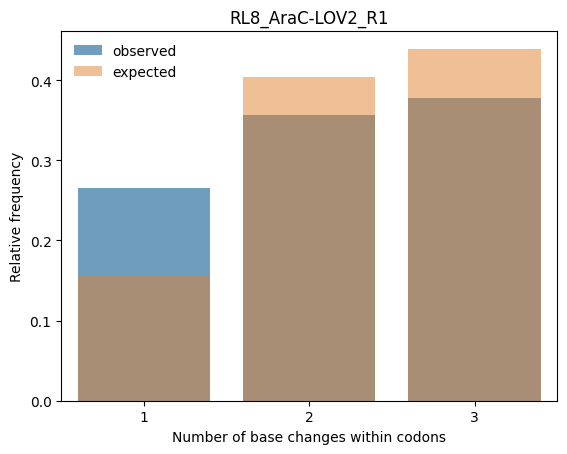

In [563]:
plt.rcdefaults()
sns.barplot(relative_Nt_changes_observed, alpha = 0.7, label = "observed")
sns.barplot(relative_expected_Nt_changes, alpha = 0.5, label = "expected")
plt.legend(frameon = False)
plt.xlabel("Number of base changes within codons")
plt.ylabel("Relative frequency")
plt.title("RL8_AraC-LOV2_R1")
plt.savefig(f"{FigFolder}/{variant}_base_changes_per_codon_exp_vs_obs.pdf")
plt.show()

In [750]:
Codon_base_bias = {key: obs/relative_expected_Nt_changes[key] for key, obs in relative_Nt_changes_observed.items()}

In [751]:
Codon_base_bias

{1: np.float64(1.7006407340123402),
 2: np.float64(0.8700318515441074),
 3: np.float64(0.8643298213964781)}

In [759]:
### use relative_Nt_changes_observed as background model 
### build background matrix
background_matrix = pd.DataFrame(0.0, index = mut_spectrum_codons_expected_vs_observed.index, columns = mut_spectrum_codons_expected_vs_observed.columns)
for ref_codon in background_matrix.index: 
    for mut_codon in background_matrix.columns: 
        if ref_codon != mut_codon:
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)])
            background_matrix.loc[ref_codon, mut_codon] = Codon_base_bias[n_changes]

background_exp_matrix = pd.DataFrame(0.0, index = mut_spectrum_codons_expected_vs_observed.index, columns = mut_spectrum_codons_expected_vs_observed.columns)
for ref_codon in background_exp_matrix.index: 
    for mut_codon in background_exp_matrix.columns: 
        if ref_codon != mut_codon:
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)])
            background_exp_matrix.loc[ref_codon, mut_codon] = relative_expected_Nt_changes[n_changes]

In [760]:
likelihood_model = mut_spectrum_codons_perc_df/background_matrix
likelihood_perc = likelihood_model/likelihood_model.sum().sum()*100
#likelihood_exp = Codon_mut_spec_expected_perc_df/background_exp_matrix
#likelihood_exp_perc = likelihood_exp/likelihood_exp.sum().sum()*100
exp_vs_obs =  Codon_mut_spec_expected_perc_df - likelihood_perc

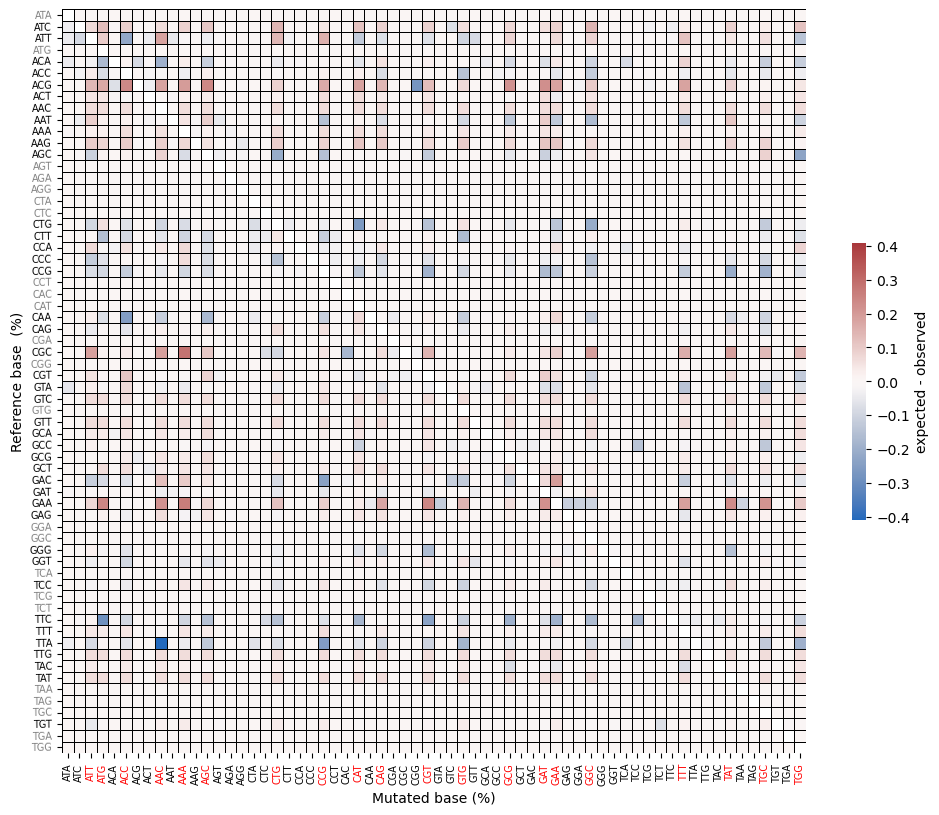

In [761]:
f, ax = plt.subplots(figsize=(12, 12))
cmap_max = np.max(abs(exp_vs_obs))
sns.heatmap(exp_vs_obs, annot=False, linewidths=.5, ax=ax,  cbar = True, square = True, linecolor = "black", cmap = "vlag",vmin = -cmap_max, vmax = cmap_max ,cbar_kws={'shrink': 0.3, "label" : "expected - observed"},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base  (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')


for i, tick_label in enumerate(ax.get_yticklabels()):
    if tick_label.get_text() not in ref_codons:
        tick_label.set_color('grey')

# plt.title(f"{name} expected vs observed mutagenic spectrum", fontsize = 12)
# plt.savefig(f"{FigFolder}/{name}_expected_vs_observed_mutagenic_spectrum_codons_perc.pdf")
plt.show()

In [677]:
Codon_mut_spec_expected_perc_df

,ATA,ATC,ATT,ATG,ACA,ACC,ACG,ACT,AAC,AAT,...,TTA,TTG,TAC,TAT,TAA,TAG,TGC,TGT,TGA,TGG
ATA,NaN,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000
ATC,0.0,NaN,0.184,0.184,0.0,0.184,0.0,0.0,0.184,0.0,...,0.0,0.0,0.0,0.184,0.0,0.0,0.184,0.0,0.0,0.184
ATT,0.0,0.0,NaN,0.307,0.0,0.307,0.0,0.0,0.307,0.0,...,0.0,0.0,0.0,0.307,0.0,0.0,0.307,0.0,0.0,0.307
ATG,0.0,0.0,0.000,NaN,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000
ACA,0.0,0.0,0.123,0.123,NaN,0.123,0.0,0.0,0.123,0.0,...,0.0,0.0,0.0,0.123,0.0,0.0,0.123,0.0,0.0,0.123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAG,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,NaN,0.000,0.0,0.0,0.000
TGC,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.0,0.000
TGT,0.0,0.0,0.061,0.061,0.0,0.061,0.0,0.0,0.061,0.0,...,0.0,0.0,0.0,0.061,0.0,0.0,0.061,NaN,0.0,0.061
TGA,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,NaN,0.000


In [664]:
mut_spectrum_codons_perc_df

,ATA,ATC,ATT,ATG,ACA,ACC,ACG,ACT,AAC,AAT,...,TTA,TTG,TAC,TAT,TAA,TAG,TGC,TGT,TGA,TGG
ATA,NaN,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
ATC,0.610,NaN,1.335,0.019,0.0,0.305,0.0,0.000,0.019,0.038,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
ATT,0.191,0.686,NaN,0.248,0.0,0.000,0.0,0.572,0.000,0.362,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
ATG,0.000,0.000,0.000,NaN,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
ACA,0.458,0.000,0.000,0.000,NaN,0.076,0.4,0.057,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAG,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,NaN,0.000,0.0,0.000,0.000
TGC,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.000,0.000
TGT,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.362,0.0,0.0,0.095,NaN,0.076,0.019
TGA,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,NaN,0.000


In [663]:
likelihood_model

,ATA,ATC,ATT,ATG,ACA,ACC,ACG,ACT,AAC,AAT,...,TTA,TTG,TAC,TAT,TAA,TAG,TGC,TGT,TGA,TGG
ATA,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
ATC,2.249242,NaN,4.922522,0.070058,0.0,1.124621,0.000000,0.000000,0.070058,0.108137,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
ATT,0.704271,2.529476,NaN,0.914446,0.0,0.000000,0.000000,2.109125,0.000000,1.334796,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
ATG,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
ACA,1.688775,0.000000,0.000000,0.000000,NaN,0.280233,1.474913,0.210175,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAG,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,NaN,0.000000,0.0,0.000000,0.000000
TGC,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,NaN,0.0,0.000000,0.000000
TGT,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.334796,0.0,0.0,0.350292,NaN,0.280233,0.070058
TGA,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,NaN,0.000000


## Compare RL8 and DP6

In [417]:
## calculate and plot the number of Nt and Codon mutations per sequence

a_seq, b_seq = read_sequences("DP6")
DP6_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_rev_read=use_rev_read, use_triplets=False)
DP6_n_Nt_mutations = dict(sorted(DP6_n_Nt_mutations.items())) ## sort dictionary after key

DP6_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_rev_read=use_rev_read, use_triplets=True)
DP6_n_Codon_mutations = dict(sorted(DP6_n_Codon_mutations.items())) ## sort dictionary after key


a_seq, b_seq = read_sequences("RL8")
RL8_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_rev_read=use_rev_read, use_triplets=False)
RL8_n_Nt_mutations = dict(sorted(RL8_n_Nt_mutations.items())) ## sort dictionary after key

RL8_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_rev_read=use_rev_read, use_triplets=True)
RL8_n_Codon_mutations = dict(sorted(RL8_n_Codon_mutations.items())) ## sort dictionary after key


total reads 59259
total reads 47233


In [429]:
RL8_n_Codon_mutation_rates
## calculate average mutation rate 
sum([key*value for value, key in RL8_n_Codon_mutation_rates.items()])/0.86

0.22148880058356332

In [428]:
RL8_n_Codon_mutation_rates

{0: 0.8384952840535205,
 1: 0.13882430357534548,
 2: 0.01930247861373108,
 3: 0.002039921035314762,
 4: 0.0005483658697082694,
 5: 0.00021934634788330776,
 6: 0.0003509541566132924,
 7: 0.00021934634788330776}

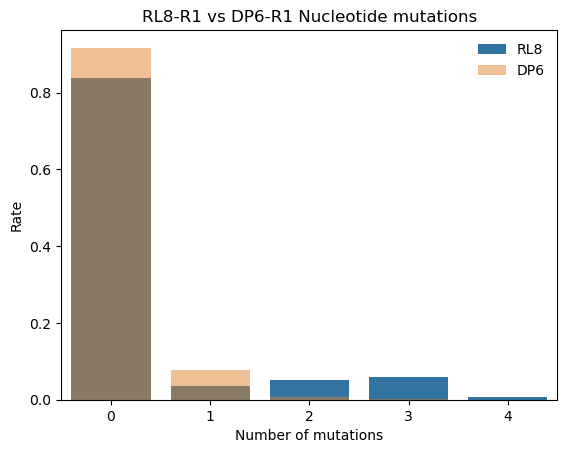

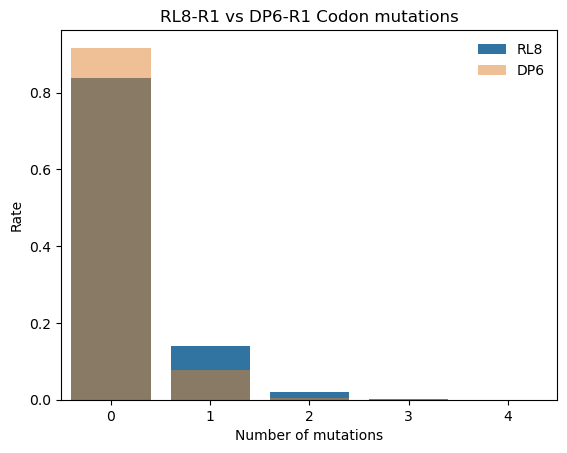

In [418]:
# rates of single, double, triple, ... mutations
total_reads = sum(DP6_n_Nt_mutations.values())
DP6_n_Nt_mutation_rates = {key: value/total_reads for key, value in DP6_n_Nt_mutations.items()}

total_reads = sum(DP6_n_Codon_mutations.values())
DP6_n_Codon_mutation_rates = {key: value/total_reads for key, value in DP6_n_Codon_mutations.items()}


total_reads = sum(RL8_n_Nt_mutations.values())
RL8_n_Nt_mutation_rates = {key: value/total_reads for key, value in RL8_n_Nt_mutations.items()}

total_reads = sum(RL8_n_Codon_mutations.values())
RL8_n_Codon_mutation_rates = {key: value/total_reads for key, value in RL8_n_Codon_mutations.items()}

sns.barplot(RL8_n_Nt_mutation_rates, label = "RL8")
sns.barplot(DP6_n_Nt_mutation_rates, alpha = 0.5, label = "DP6")
plt.legend(frameon = False)
plt.xlim(-0.5,4.5)
plt.xlabel('Number of mutations')
plt.ylabel('Rate')
plt.title(f'{variant}-R1 vs DP6-R1 Nucleotide mutations') 
plt.savefig(f'figures/RL8-R1_vs_DP6-R1_n_Nt_mutation_per_read_rates.pdf')
plt.show()
plt.clf()

sns.barplot(RL8_n_Codon_mutation_rates, label = "RL8")
sns.barplot(DP6_n_Codon_mutation_rates, alpha = 0.5, label = "DP6")
plt.legend(frameon = False)
plt.xlim(-0.5,4.5)
plt.xlabel('Number of mutations')
plt.ylabel('Rate')
plt.title(f'{variant}-R1 vs DP6-R1 Codon mutations') 
plt.savefig(f'figures/RL8-R1_vs_DP6-R1_n_Codon_mutation_per_read_rates.pdf')
plt.show()